In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

matplotlib.rcParams['legend.handlelength'] = 1
matplotlib.rcParams['legend.handleheight'] = 1

plt.rc('figure', facecolor='w')

In [2]:
data = np.loadtxt('B3LYP/errors.dat')

In [3]:
def zip_object(keys, values):
    return {k: v for k, v in zip(keys, values)}

names_raw = ['vac_ml', 'vac_mm', 'vac_qm', 's_full', 's_nopol', 's_mech', 's_mechmm', 's_mm', 's_qm']
data_dict = zip_object(names_raw, data)

In [4]:
vac_names = ['vac_ml', 'vac_mm']
wat_names = ['s_full', 's_nopol', 's_mech', 's_mechmm', 's_mm']
shift_names = [name + '_shift' for name in wat_names]

errors = [
    *[data_dict[name] - data_dict['vac_qm'] for name in vac_names],
    *[data_dict[name] - data_dict['s_qm'] for name in wat_names]
]
errors_dict = zip_object(vac_names + wat_names, errors)

# append shift values
for name in wat_names[:-1]:
    values = errors_dict[name]
    errors_dict[name] = np.concatenate([values, values - errors_dict['vac_ml']])
mm_err = errors_dict['s_mm']
errors_dict['s_mm'] = np.concatenate([mm_err, mm_err - errors_dict['vac_mm']])

cols = ['La_dE', 'La_mu', 'Lb_dE', 'Lb_mu']
cols_shift = [col + '_shift' for col in cols]
bars_data = {k: zip_object(cols + cols_shift, v) for k, v in errors_dict.items()}

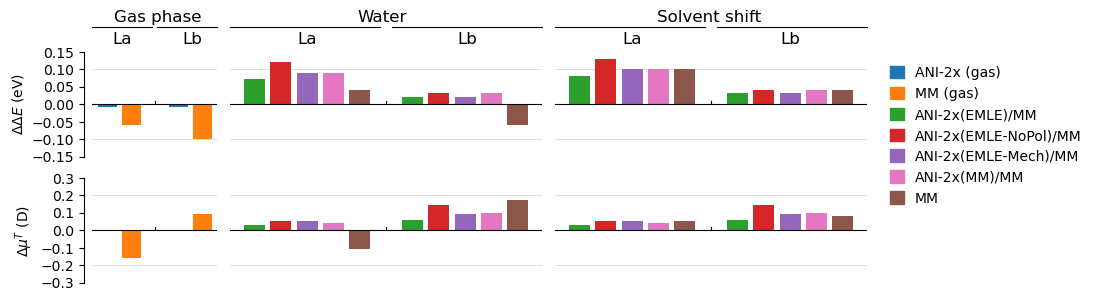

In [5]:
COLORS = {
    'vac_ml': '#1f77b4',    # Blue
    'vac_mm': '#ff7f0e',    # Orange
    's_full': '#2ca02c',    # Green
    's_nopol': '#d62728',   # Red
    's_mech': '#9467bd',    # Purple
    's_mechmm': '#e377c2',  # Pink
    's_mm': '#8c564b',      # Brown
}

LABELS = {
    'vac_ml': 'ANI-2x (gas)',
    'vac_mm': 'MM (gas)',
    's_full': 'ANI-2x(EMLE)/MM',
    's_nopol': 'ANI-2x(EMLE-NoPol)/MM',
    's_mech': 'ANI-2x(EMLE-Mech)/MM',
    's_mechmm': 'ANI-2x(MM)/MM',
    's_mm': 'MM'
}

def names_to_bars(names, value_tags, values_dict, colors_dict):
    n = len(names)
    height = []
    color = []
    x = []
    for i, value_tag in enumerate(value_tags):
        height.extend([values_dict[name][value_tag] for name in names])
        color.extend([colors_dict[name] for name in names])
        x.extend(np.arange(n) + i * (n + 1))
    return {'x': x, 'height': height, 'color': color}


bars = {
    'E_gas': names_to_bars(vac_names, ['La_dE', 'Lb_dE'], bars_data, COLORS),
    'E_wat': names_to_bars(wat_names, ['La_dE', 'Lb_dE'], bars_data, COLORS),
    'E_shift': names_to_bars(wat_names, ['La_dE_shift', 'Lb_dE_shift'], bars_data, COLORS),
    'mu_gas': names_to_bars(vac_names, ['La_mu', 'Lb_mu'], bars_data, COLORS),
    'mu_wat': names_to_bars(wat_names, ['La_mu', 'Lb_mu'], bars_data, COLORS),
    'mu_shift': names_to_bars(wat_names, ['La_mu_shift', 'Lb_mu_shift'], bars_data, COLORS)
}
ranges = {'E': [-0.15, 0.15], 'mu': [-0.3, 0.30]}
ticks = {'E': np.linspace(-0.15, 0.15, 7), 'mu': np.linspace(-0.3, 0.3, 7)}
xlabels = {'E': '$\Delta \Delta E$ (eV)', 'mu': '$\Delta \mu^{T}$ (D)'}

fig, axs = plt.subplot_mosaic([['E_gas', 'E_wat', 'E_shift'], 
                               ['mu_gas', 'mu_wat', 'mu_shift']], 
                              figsize=(10,3), 
                              gridspec_kw={'wspace': 0.05, 'hspace': 0.2, 'width_ratios': [2,5,5]})

for prefix in ['E', 'mu']:
    
    for group in ['gas', 'wat', 'shift']:
        name = prefix + '_' + group
        ax = axs[name]
        ax.axhline(y=0, color='black', linewidth=0.8)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)    
        ax.bar(**bars[name])
        ax.set_xticks([])
        ax.set_ylim(*ranges[prefix])
        ax.set_yticks(ticks[prefix])
        
        if group == 'gas':
            ax.set_ylabel(xlabels[prefix])
            ax.axvline(2, c='black', linewidth=0.8, ymin=0.5, ymax=0.53)
            ax.spines['left'].set_position(('data', -1))
            ax.spines['left'].set_visible(True)
        else:
            ax.axvline(5, c='black', linewidth=0.8, ymin=0.5, ymax=0.53)
            ax.yaxis.set_visible(False)
            ax.spines['left'].set_visible(False)

        if prefix == 'E':
            ax.axhline(y=0.22, xmin=0, xmax=0.48, color='black', linewidth=0.8, clip_on=False)
            ax.axhline(y=0.22, xmin=0.52, xmax=1 , color='black', linewidth=0.8, clip_on=False)
            ax.axhline(y=-0.1, color='lightgrey', linewidth=0.5, zorder=-1)
            ax.axhline(y=0.1, color='lightgrey', linewidth=0.5, zorder=-1)
        else:
            ax.axhline(y=-0.2, color='lightgrey', linewidth=0.5, zorder=-1)
            ax.axhline(y=0.2, color='lightgrey', linewidth=0.5, zorder=-1)

legend_items = []
for name in vac_names + wat_names:
    legend_items.append(
        mpatches.Patch(color=COLORS[name], label=LABELS[name])
    )

TOP_TEXT_Y = 0.98
BOTTOM_TEXT_Y = 0.905

fig.text(0.147, TOP_TEXT_Y, 'Gas phase', fontsize='large')
fig.text(0.39, TOP_TEXT_Y, 'Water', fontsize='large')
fig.text(0.69, TOP_TEXT_Y, 'Solvent shift', fontsize='large')
fig.text(0.145, BOTTOM_TEXT_Y, 'La', fontsize='large')
fig.text(0.215, BOTTOM_TEXT_Y, 'Lb', fontsize='large')
fig.text(0.33, BOTTOM_TEXT_Y, 'La', fontsize='large')
fig.text(0.49, BOTTOM_TEXT_Y, 'Lb', fontsize='large')
fig.text(0.655, BOTTOM_TEXT_Y, 'La', fontsize='large')
fig.text(0.813, BOTTOM_TEXT_Y, 'Lb', fontsize='large')

fig.legend(handles=legend_items, loc='center left', bbox_to_anchor=(0.91, 0.6), ncol=1, frameon=False)
plt.savefig('FigS5.png', dpi=300, bbox_inches='tight')
                
plt.show()